# Data Labeling

This notebook contains all the relevant information gathered from other notebooks. Specifically how data labeling was achieved.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_folder = '../data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'

reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)

vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
vendors.dropna(how='all', inplace=True)

reports_vendors = reports.join(vendors, how='inner')

First we look at how many classified samples we have out of the total samples:

In [2]:
display('{} classified samples from a total of {} ({:.2f}%)'.format(len(vendors), len(reports),
                                                                    100*len(vendors)/len(reports)))

'292127 classified samples from a total of 397436 (73.50%)'

## Choosing a threshold

The reports contain the classification given by a high number of vendors. Since not all agree on what is malware and what is not, there needs to be a minimum number of vendors to consider a sample as malware.

To help choose this number, we identify all duplicated samples and look at how the number of vendors that classify a sample as malware changes. This mainly shows two things: the vendors tendency for FP/FN and how likely it is for samples to have their classification change by a number of vendors.

In [3]:
md5_dups = set(reports_vendors[reports_vendors.md5.duplicated()].md5)
reports_duplicated = reports_vendors[reports_vendors.md5.isin(md5_dups)]
reports_duplicated.is_copy = False
display('{} duplicated samples from {} unique md5\'s'.format(len(reports_duplicated), len(md5_dups)))
vendors_count = reports_duplicated.replace('Clean', np.nan)
vendors_count = vendors_count.groupby(['md5', 'date']).count().sum(axis=1).reset_index('date')

"78451 duplicated samples from 28996 unique md5's"

In [4]:
%%time
differences = []
# For differences in first and last submission
differences_fl = []
# Calculate the pairwise difference between reports
for md5 in vendors_count.index.unique():
    temp = vendors_count[vendors_count.index == md5].sort_values('date', ascending=False)
    count = list(temp[0])
    if sum(count) == 0:
        continue
    differences_fl += [count[0] - count[-1]]
    differences += [x - y for x, y in zip(count, count[1:])]

CPU times: user 3min 22s, sys: 115 ms, total: 3min 22s
Wall time: 3min 22s


The following graph represents the proportion of differences between consecutive scans, showing that the tendency is to increase the number of classifications, rather than decreasing. This represents how vendors tend to be conservative on their classification, favoring false negatives over false positives.

The high proportion in low increases show that vendors incrementally change their classification, meaning that detection differs between vendors. This indicates that some vendors are better at detection than others.

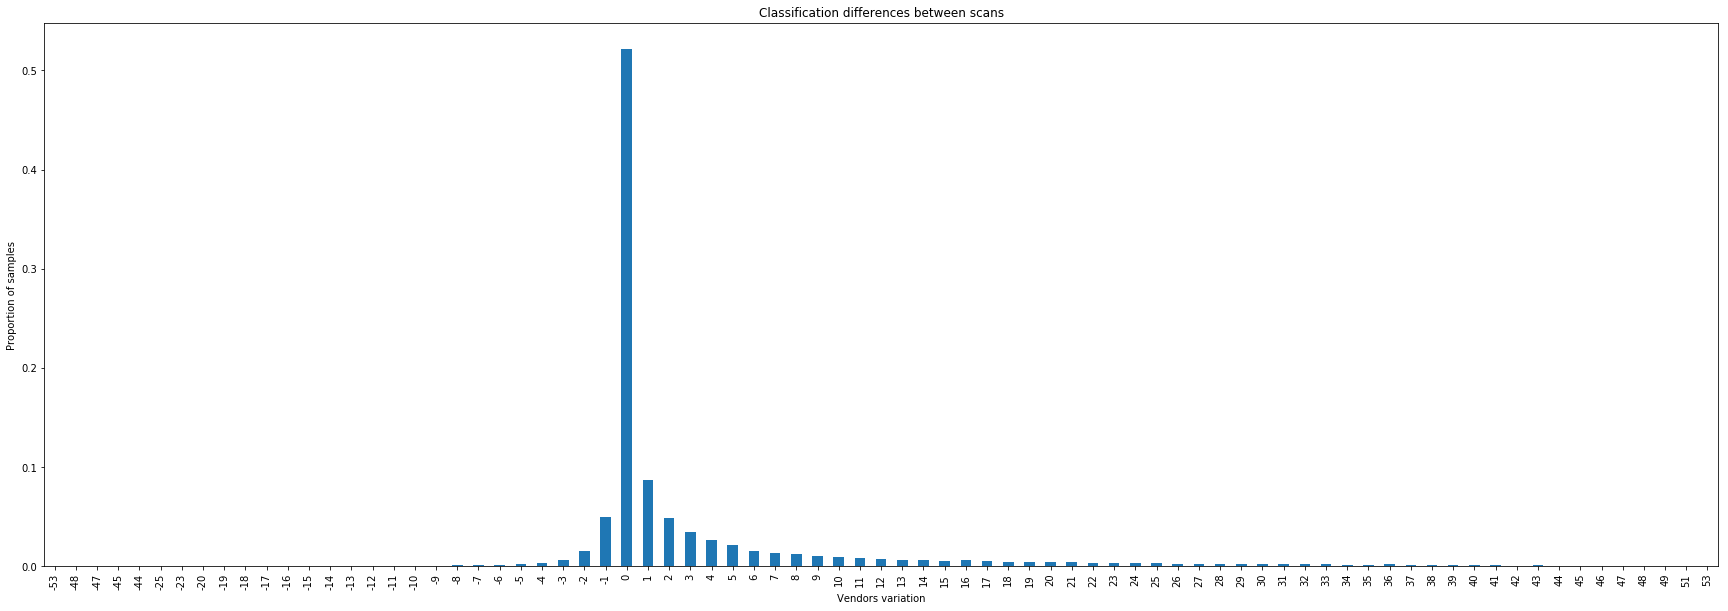

In [5]:
diff_percent = pd.Series(differences)
diff_percent = diff_percent.value_counts().sort_index().divide(len(diff_percent))
ax = diff_percent.plot.bar(figsize=((30, 10)), title='Classification differences between scans')
ax.set_xlabel('Vendors variation')
ax.set_ylabel('Proportion of samples')
plt.show()

The following graph shows the same metric as the previous one, but only takes into account the difference between first and last scans.

This graph allows a threshold to be chosen. This threshold is the minimum number of vendors $V$ needed to label a sample from the dataset as malware.

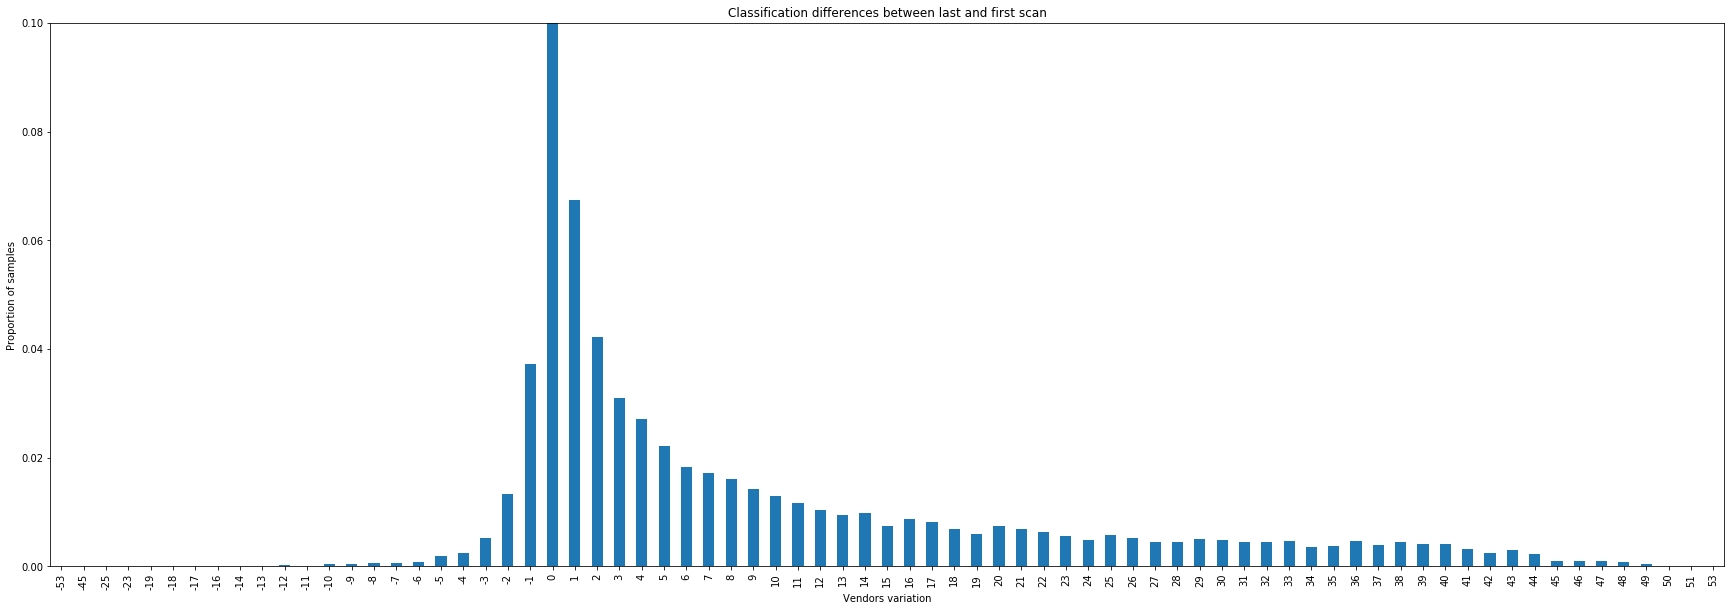

In [6]:
diff_fl_percent = pd.Series(differences_fl)
diff_fl_percent = diff_fl_percent.value_counts().sort_index().divide(len(diff_fl_percent))
ax2 = diff_fl_percent.plot.bar(figsize=((30, 10)), ylim=(0, 0.1),
                               title='Classification differences between last and first scan')
ax2.set_xlabel('Vendors variation')
ax2.set_ylabel('Proportion of samples')
plt.show()

In [7]:
display('Samples that go from 5 vendors to none: {:.2f}%'.format(
    diff_fl_percent[diff_fl_percent.index <= -5].sum()*100))
display('Samples that go from 5 vendors to one: {:.2f}%'.format(
    diff_fl_percent[diff_fl_percent.index <= -4].sum()*100))

'Samples that go from 5 vendors to none: 0.57%'

'Samples that go from 5 vendors to one: 0.81%'

Choosing a threshold $V=5$ gives a confidence of $1 - \sum_{n=-4}^{-\infty} P(n) = 1 - 0.0057 = 0.9943$ that a sample will not become clean (i.e. at least one vendor will still classify it as malware).

## Choosing pioneers

Given that some vendors have a higher detection rate than others, by filtering the number of vendors to those with higher detection rate, a higher confidence of a sample being malware can be achieved.

Before filtering by detection rate, one initial requirement is that vendors must have classified a great majority of the dataset.

In [8]:
vendors_presence = vendors.count()/len(vendors)
majority_vendors = list(vendors_presence[vendors_presence >= 0.9].index)
display('Vendors that classified 90% or more of the dataset: {}'.format(len(majority_vendors)))
display(', '.join(majority_vendors))

'Vendors that classified 90% or more of the dataset: 38'

'AVG, AhnLab-V3, Antiy-AVL, Avast, BitDefender, CAT-QuickHeal, ClamAV, Comodo, DrWeb, ESET-NOD32, Emsisoft, F-Prot, F-Secure, Fortinet, GData, Ikarus, Jiangmin, K7AntiVirus, K7GW, Kaspersky, Malwarebytes, McAfee, McAfee-GW-Edition, MicroWorld-eScan, Microsoft, NANO-Antivirus, Panda, Rising, SUPERAntiSpyware, Sophos, Symantec, TheHacker, TrendMicro, TrendMicro-HouseCall, VBA32, VIPRE, ViRobot, nProtect'

In [9]:
# Remove other vendors from the frames
reports_vendors.drop(set(reports_vendors.columns).difference(
    set(majority_vendors + ['md5', 'date'])), axis=1, inplace=True)
vendors.drop(set(vendors.columns).difference(
    set(majority_vendors)), axis=1, inplace=True)
reports_duplicated.drop(set(reports_duplicated.columns).difference(
    set(majority_vendors + ['md5', 'date'])), axis=1, inplace=True)

With a smaller set of vendors, one interesting metric to see is how much vendors change their classification between scans, which reflects their own confidence.

The following graph shows the percentage of changed classifications for each vendor.

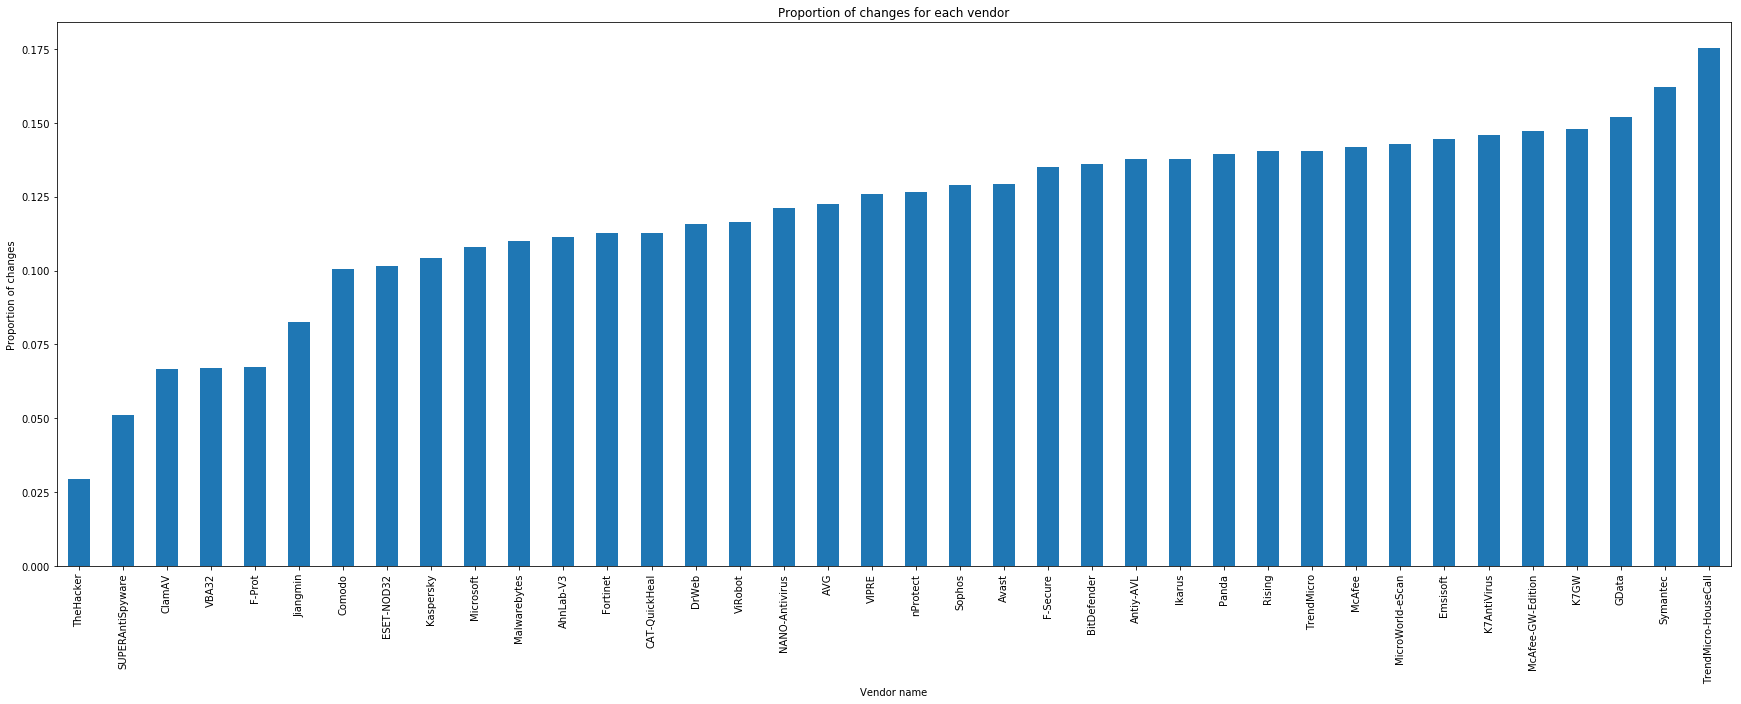

In [10]:
# vendors_confidence.csv.gz was created by "3 - Vendors.csv analysis" and contains variation for all vendors
vendors_confidence = pd.read_csv(data_folder + 'vendors_confidence.csv.gz')
vendors_confidence = vendors_confidence.set_index('vendors')
# Filter for high presence vendors only
vendors_confidence = vendors_confidence[vendors_confidence.index.isin(vendors.columns)]
vendors_confidence = vendors_confidence[vendors_confidence.changes != 0]['ratio'].sort_values()
ax3 = vendors_confidence.plot.bar(figsize=((30, 10)), title='Proportion of changes for each vendor')
ax3.set_xlabel('Vendor name')
ax3.set_ylabel('Proportion of changes')
plt.show()

To filter the vendors with high detection rate, the previously chosen threshold is used to assert malware samples.

In [11]:
malware_duplicates = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
malware_duplicates.drop(set(list(malware_duplicates.columns)).difference(
    set(majority_vendors  + ['date', 'md5'])), axis=1, inplace=True)
malware_duplicates.replace('Clean', np.nan, inplace=True)
# Threshold is 5, + 2 for md5 and date column
malware_duplicates = malware_duplicates[malware_duplicates.count(axis=1) >= 5 + 2]

From the duplicates that cross over the threshold in their final submission, check which vendors classify them as malware on the **last submission**.

In [12]:
malware_last = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
malware_last = malware_last[malware_last.md5.isin(malware_duplicates.md5)].drop(['md5', 'date'], axis=1)
malware_last.replace('Clean', np.nan, inplace=True)
reliable = malware_last.count().divide(len(malware_last)).sort_values()

The following graph shows the calculated detection rate for each vendor, based on the chosen threshold (at least 5 vendors by the last submission).

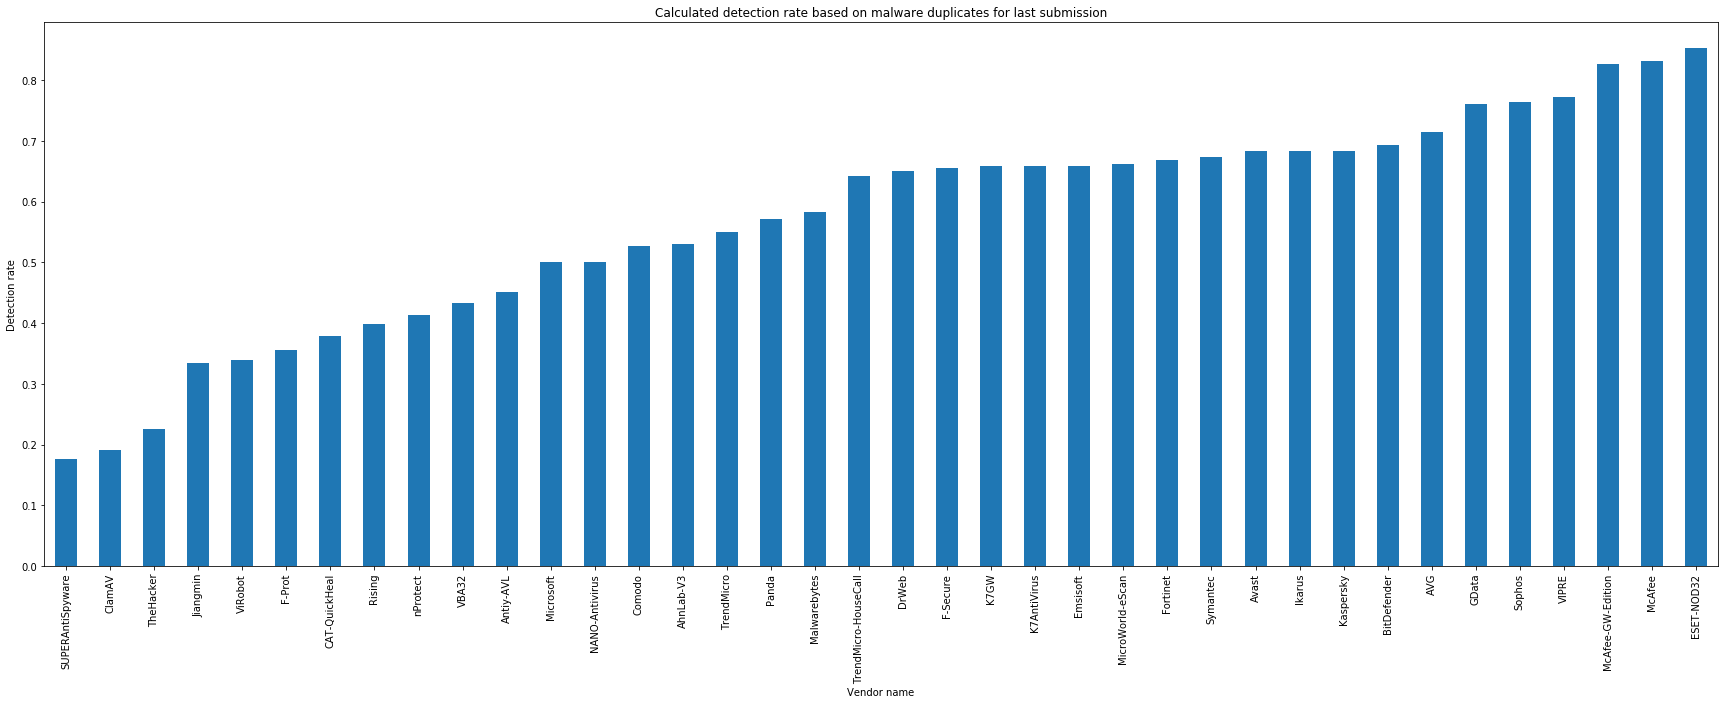

In [13]:
ax = reliable.plot.bar(figsize=((30, 10)),
                       title='Calculated detection rate based on malware duplicates for last submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()

From the duplicates that cross over the threshold in their final submission, check which vendors classify them as malware on the **first submission**.

In [14]:
malware_first = reports_duplicated.sort_values('date').drop_duplicates(keep='first', subset='md5')
malware_first = malware_first[malware_first.md5.isin(malware_duplicates.md5)].drop(['md5', 'date'], axis=1)
malware_first.replace('Clean', np.nan, inplace=True)
pioneers = malware_first.count().divide(len(malware_first)).sort_values()

The following graph shows the calculated detection rate for each vendor, based on the chosen threshold (at least 5 vendors by the last submission).

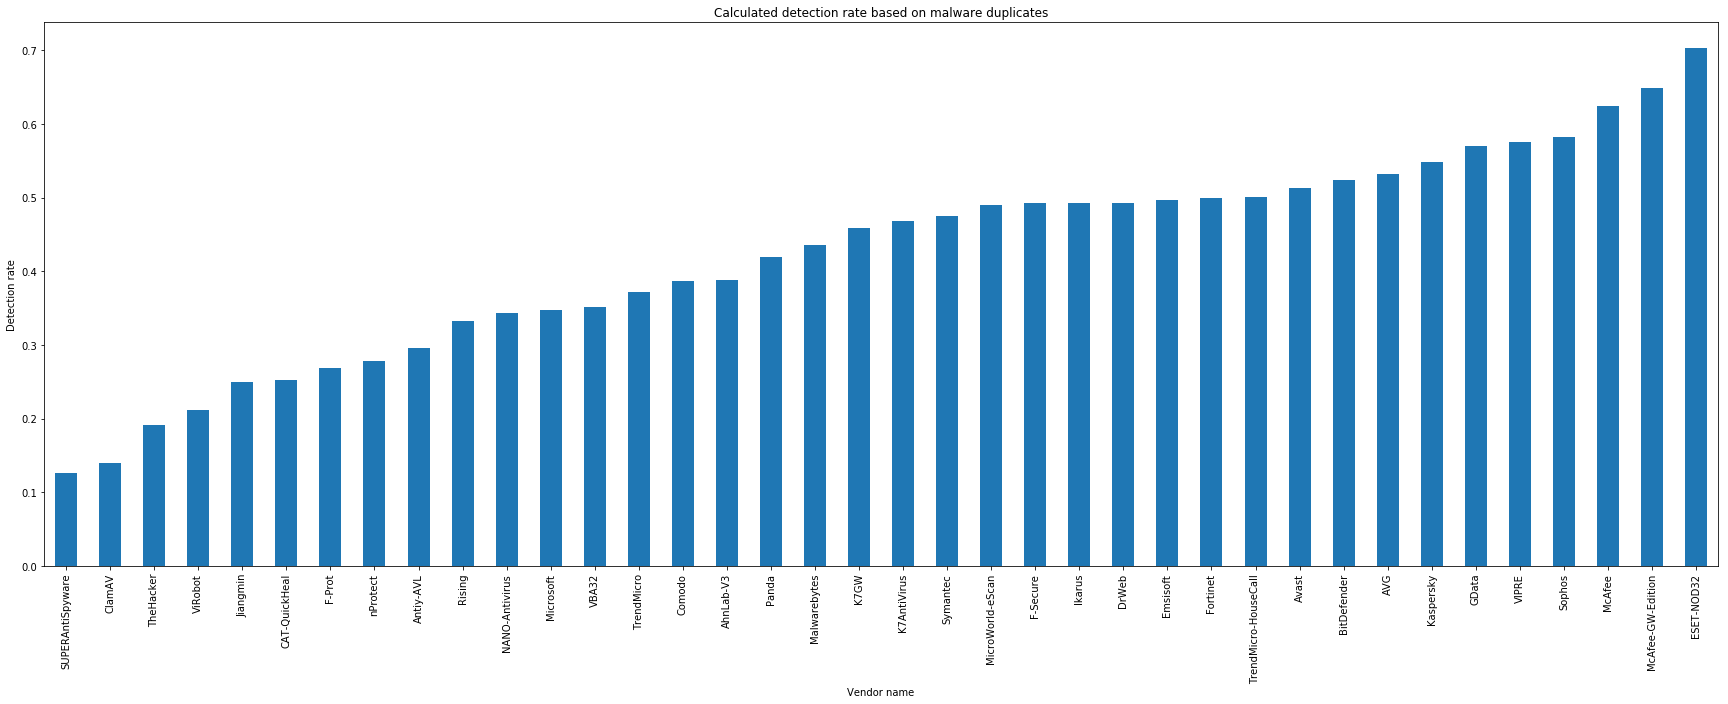

In [15]:
ax = pioneers.plot.bar(figsize=((30, 10)), title='Calculated detection rate based on malware duplicates')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()

The following graph shows the calculated detection rate for each vendor, both on first and last submission.

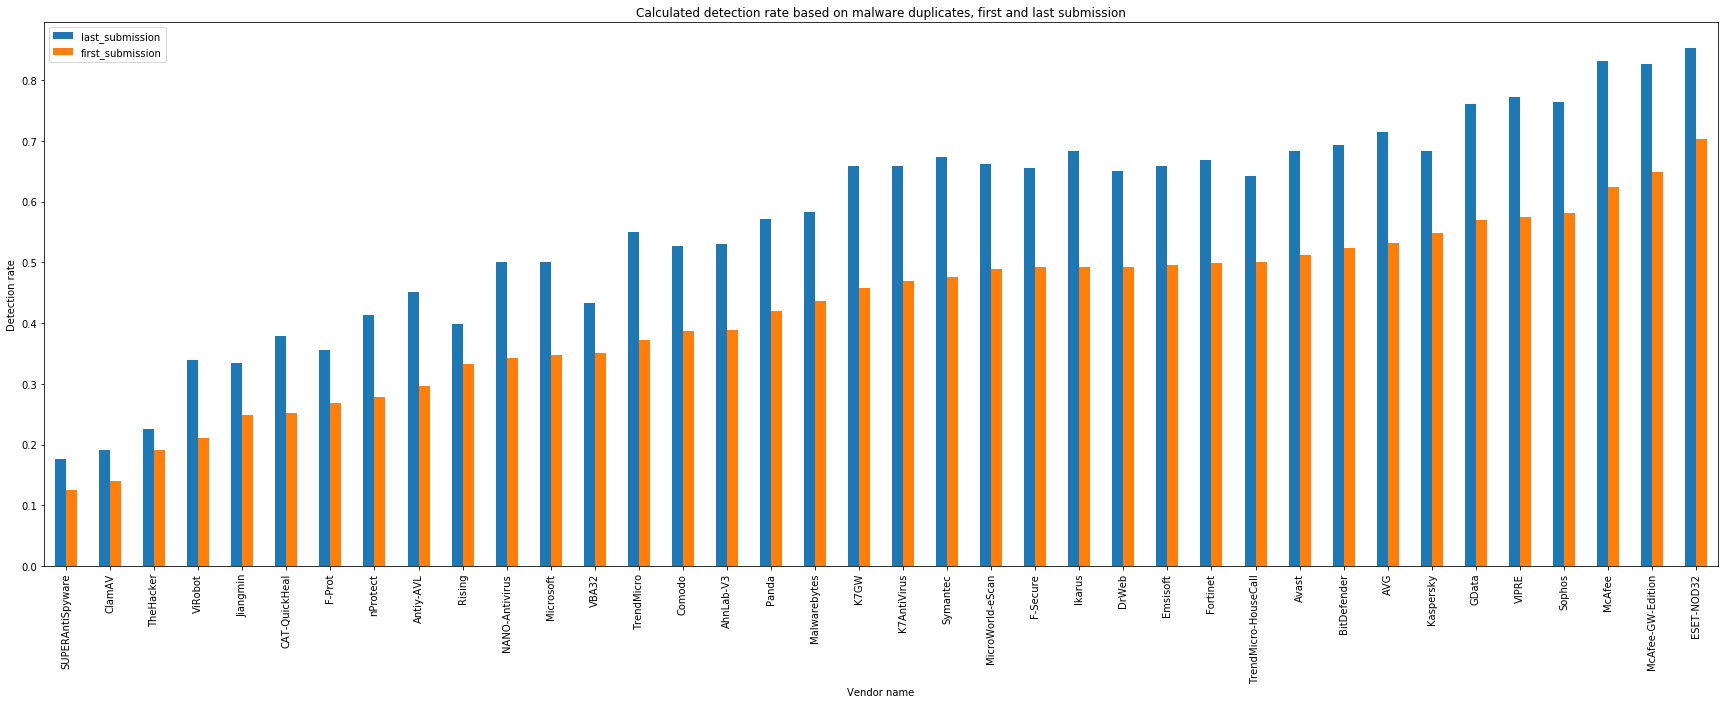

'Vendors with over 30% calculated detection rate in both first and last submission:'

,last_submission,first_submission
Rising,0.399277,0.331973
NANO-Antivirus,0.500671,0.342820
Microsoft,0.500000,0.347572
VBA32,0.432490,0.351446
TrendMicro,0.549432,0.372211
Comodo,0.526291,0.386415
AhnLab-V3,0.530630,0.388481
Panda,0.571281,0.419783
Malwarebytes,0.583161,0.436260
K7GW,0.659039,0.458523


'Total vendors: 29'

In [16]:
first_last_detections = pd.concat([reliable, pioneers], axis=1)
first_last_detections.columns = ['last_submission', 'first_submission']
ax = first_last_detections.sort_values('first_submission').plot.bar(figsize=((30, 10)),
                        title='Calculated detection rate based on malware duplicates, first and last submission')
ax.set_xlabel('Vendor name')
ax.set_ylabel('Detection rate')
plt.show()
display('Vendors with over 30% calculated detection rate in both first and last submission:')
display(first_last_detections[(first_last_detections.first_submission >= 0.3) &
                              (first_last_detections.last_submission >=0.3)].sort_values('first_submission'))
display('Total vendors: {}'.format(len(first_last_detections[(first_last_detections.first_submission >= 0.3) &
                                                     (first_last_detections.last_submission >=0.3)])))

## Validating chosen vendors

How the chosen vendors behave on clean samples (i.e. samples where the in the last submission all vendors say it's clean).

Filter samples that are clean by the last submission:

In [17]:
selected_vendors = list(first_last_detections[(first_last_detections.first_submission >= 0.3) &
                              (first_last_detections.last_submission >=0.3)].sort_values('first_submission').index)
clean_duplicates = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
# Filter where everyone say it's clean, 29 vendors
clean_duplicates = clean_duplicates[(clean_duplicates[selected_vendors] == 'Clean').sum(axis=1) == 29]
display('Clean samples by the last submission: {}'.format(len(clean_duplicates)))

'Clean samples by the last submission: 4325'

From the clean samples, check who classified them as clean on the first submission:

In [18]:
clean_first = reports_duplicated.sort_values('date').drop_duplicates(keep='first', subset='md5')
clean_first = clean_first[clean_first.md5.isin(clean_duplicates.md5)].drop(['md5', 'date'], axis=1)
clean_first = clean_first[selected_vendors]
clean_pioneers = clean_first[(clean_first == 'Clean')].count().divide(len(clean_first)).sort_values()

The following graph shows the calculated TN rate for the selected 29 vendors.

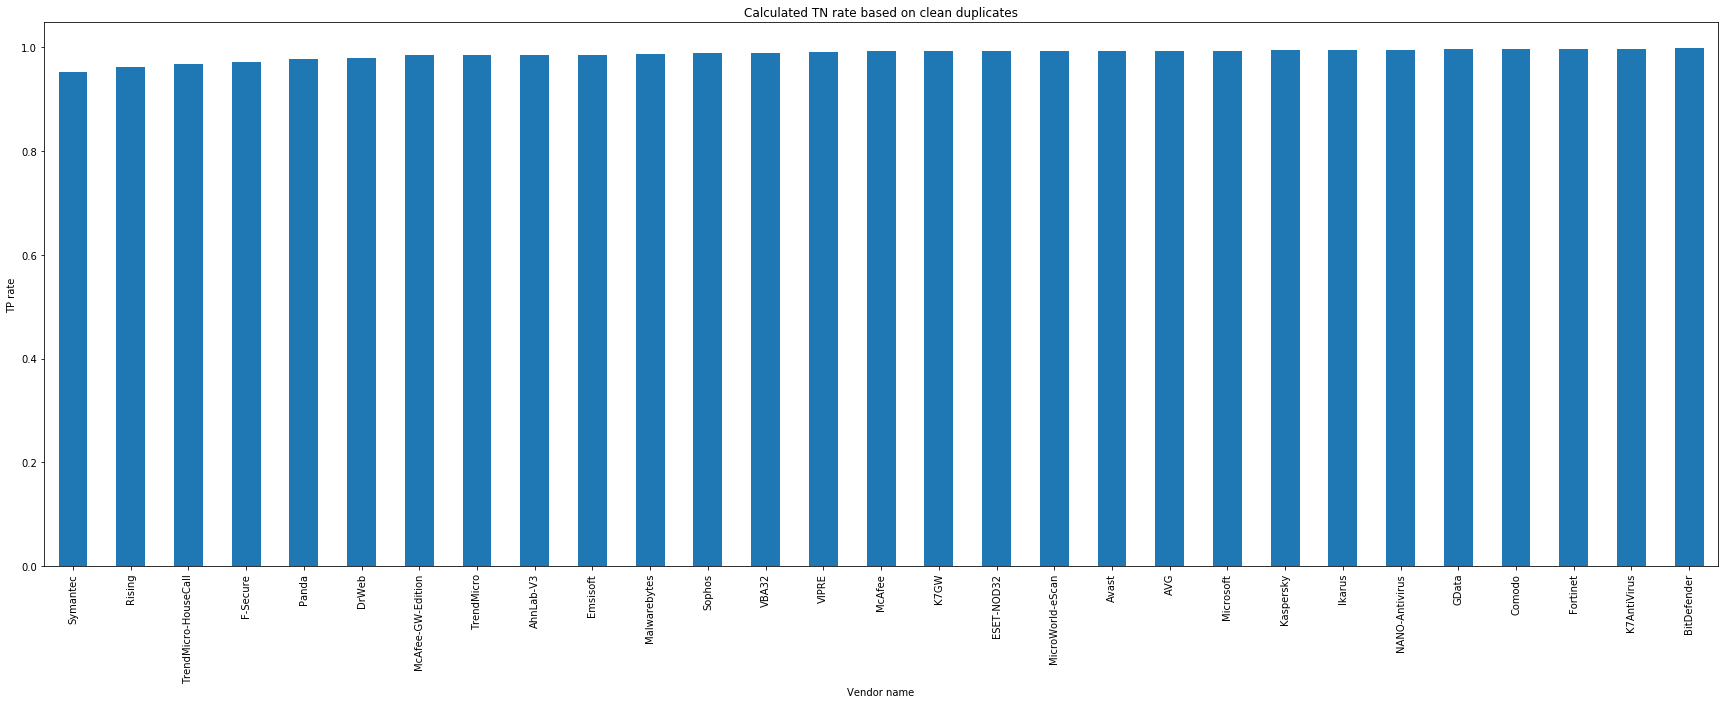

Symantec                0.951676
Rising                  0.961387
TrendMicro-HouseCall    0.967630
F-Secure                0.971329
Panda                   0.977572
DrWeb                   0.978728
McAfee-GW-Edition       0.984509
TrendMicro              0.984971
AhnLab-V3               0.985665
Emsisoft                0.985896
Malwarebytes            0.988208
Sophos                  0.988439
VBA32                   0.988902
VIPRE                   0.990520
McAfee                  0.992139
K7GW                    0.992139
ESET-NOD32              0.992370
MicroWorld-eScan        0.993295
Avast                   0.993526
AVG                     0.993526
Microsoft               0.993988
Kaspersky               0.994913
Ikarus                  0.995145
NANO-Antivirus          0.995376
GData                   0.996069
Comodo                  0.996069
Fortinet                0.997457
K7AntiVirus             0.997688
BitDefender             0.998150
dtype: float64

In [19]:
ax = clean_pioneers.plot.bar(figsize=((30, 10)),
                        title='Calculated TN rate based on clean duplicates')
ax.set_xlabel('Vendor name')
ax.set_ylabel('TP rate')
plt.show()
display(clean_pioneers)

## Entry-level classifications

In [20]:
malware_vendor_frequency = malware_first.count(axis=1).value_counts().sort_index()

The following graph shows the frequency for count of vendors that classify a sample as malware by the first submission, when it's actually malware

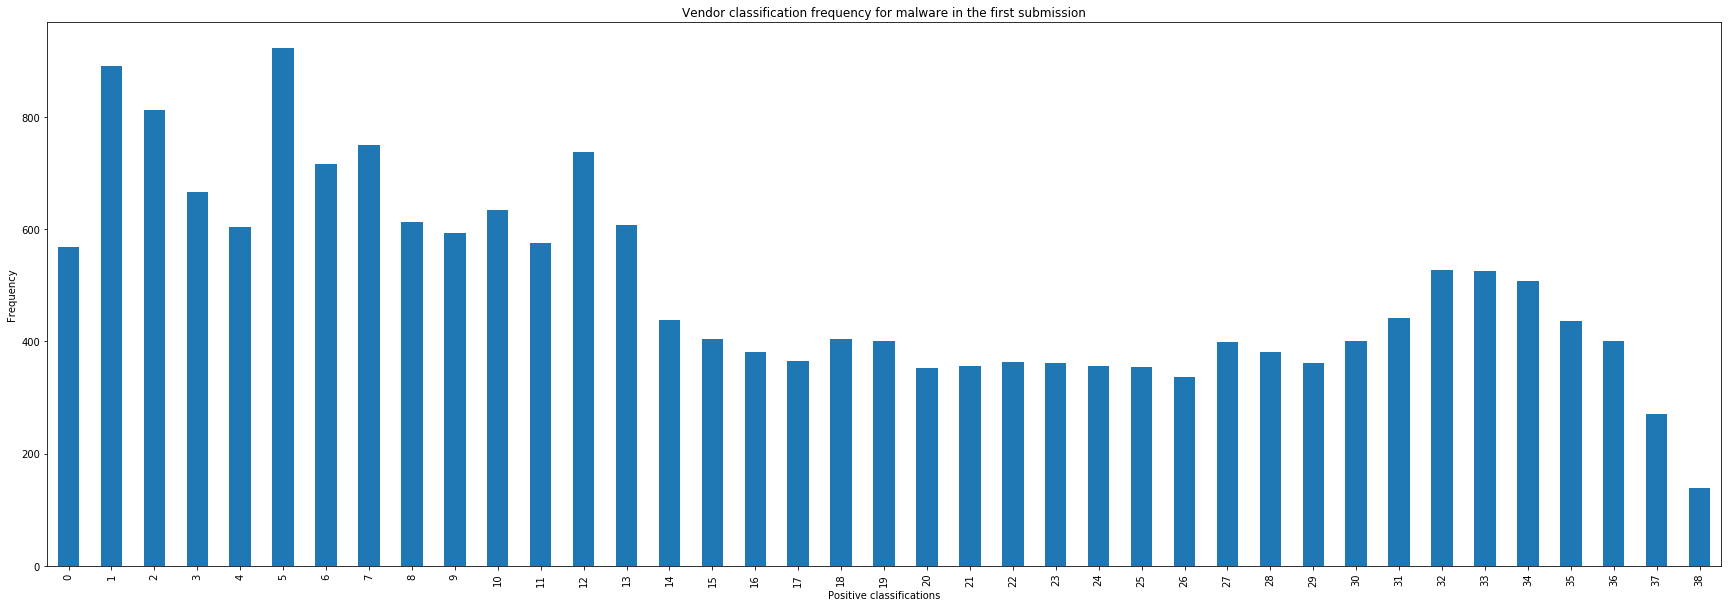

In [64]:
ax = malware_vendor_frequency.plot.bar(figsize=((30, 10)),
                                  title='Vendor classification frequency for malware in the first submission')
ax.set_xlabel('Positive classifications')
ax.set_ylabel('Frequency')
plt.show()

## Proportion of changes

Check if vendors correct their classifications to reflect the actual label, or the opposite.

In [79]:
malware_proportion = reports_duplicated.sort_values('date').drop_duplicates(keep='first', subset='md5')
malware_proportion = malware_proportion[malware_proportion.md5.isin(malware_duplicates.md5)]
malware_proportion2 = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
malware_proportion2 = malware_proportion2[malware_proportion2.md5.isin(malware_duplicates.md5)]

clean_proportion = reports_duplicated.sort_values('date').drop_duplicates(keep='first', subset='md5')
clean_proportion = clean_proportion[clean_proportion.md5.isin(clean_duplicates.md5)]
clean_proportion2 = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
clean_proportion2 = clean_proportion2[clean_proportion2.md5.isin(clean_duplicates.md5)]

The following graph shows the proportion of malware samples that went from clean on the first submission to malware in the last.

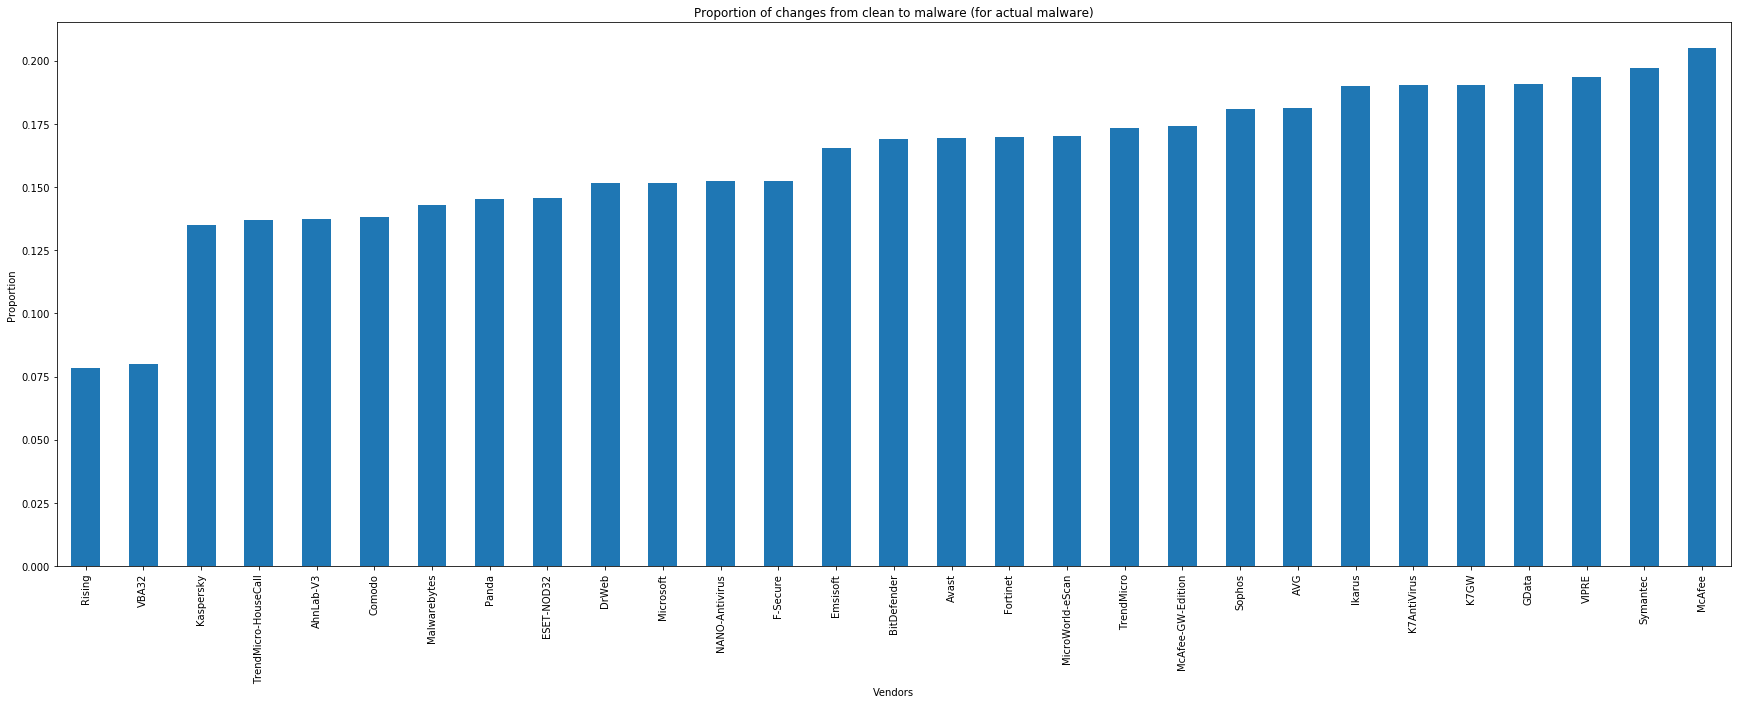

In [89]:
vendors_changes = dict()

for vendor in selected_vendors:
    first = malware_proportion[vendor].dropna().replace('Clean', np.nan)
    last = malware_proportion2[vendor].dropna().replace('Clean', np.nan)

    vendors_changes[vendor] = (len(first[first.isnull()]) - len(last[last.isnull()])) / len(malware_last)

ax = pd.Series(vendors_changes).sort_values().plot.bar(figsize=((30, 10)),
    title='Proportion of changes from clean to malware (for actual malware)')
ax.set_xlabel('Vendors')
ax.set_ylabel('Proportion')
plt.show()

The following graph shows the proportion of malware samples that went from malware on the first submission to clean in the last.

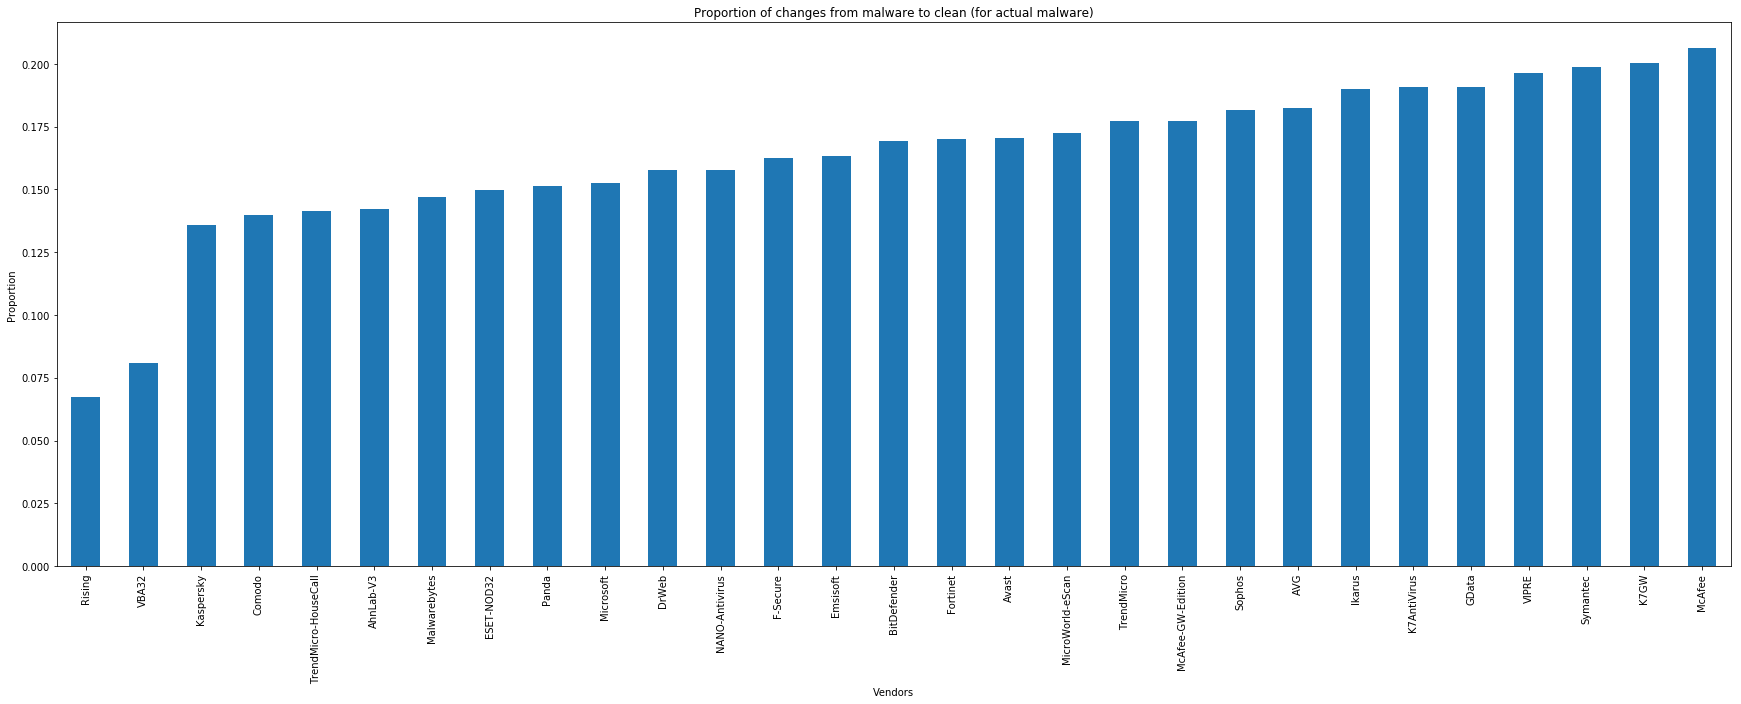

In [96]:
vendors_changes2 = dict()

for vendor in selected_vendors:
    first = malware_proportion[vendor].dropna().replace('Clean', np.nan)
    last = malware_proportion2[vendor].dropna().replace('Clean', np.nan)

    vendors_changes2[vendor] = (len(last[~last.isnull()]) - len(first[~first.isnull()])) / len(malware_last)

ax = pd.Series(vendors_changes2).sort_values().plot.bar(figsize=((30, 10)),
    title='Proportion of changes from malware to clean (for actual malware)')
ax.set_xlabel('Vendors')
ax.set_ylabel('Proportion')
plt.show()

The following graph shows the proportion of clean samples that went from clean on the first submission to malware in the last.

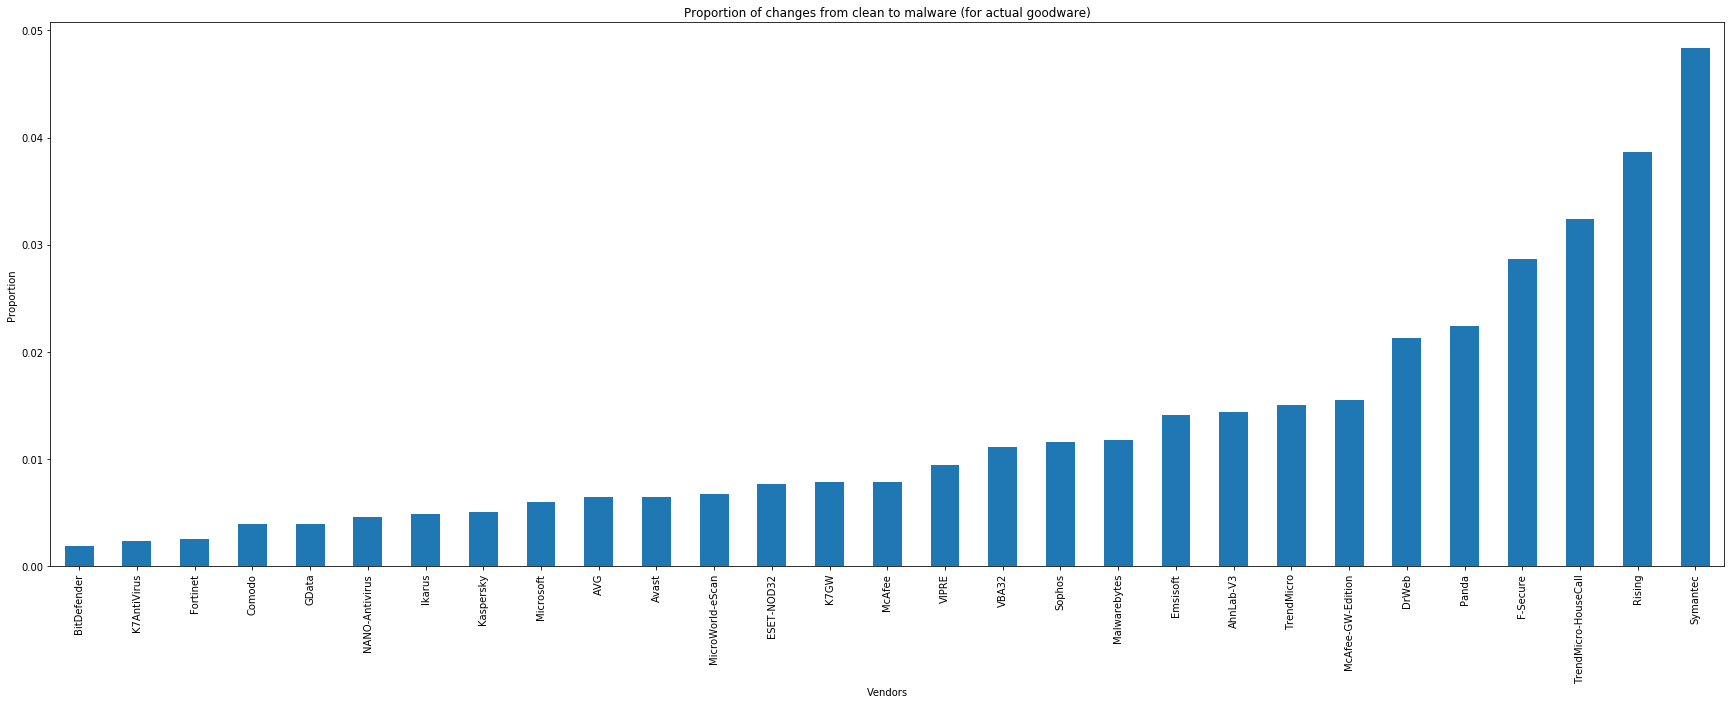

In [102]:
vendors_changes3 = dict()

clean_last = reports_duplicated.sort_values('date').drop_duplicates(keep='last', subset='md5')
clean_last = clean_last[clean_last.md5.isin(clean_duplicates.md5)].drop(['md5', 'date'], axis=1)
clean_last = clean_last[selected_vendors]

for vendor in selected_vendors:
    first = clean_proportion[vendor].dropna().replace('Clean', np.nan)
    last = clean_proportion2[vendor].dropna().replace('Clean', np.nan)

    vendors_changes3[vendor] = (len(last[last.isnull()]) - len(first[first.isnull()])) / len(clean_last)

ax = pd.Series(vendors_changes3).sort_values().plot.bar(figsize=((30, 10)),
    title='Proportion of changes from clean to malware (for actual goodware)')
ax.set_xlabel('Vendors')
ax.set_ylabel('Proportion')
plt.show()

The following graph shows the proportion of clean samples that went from malware on the first submission to clean in the last.

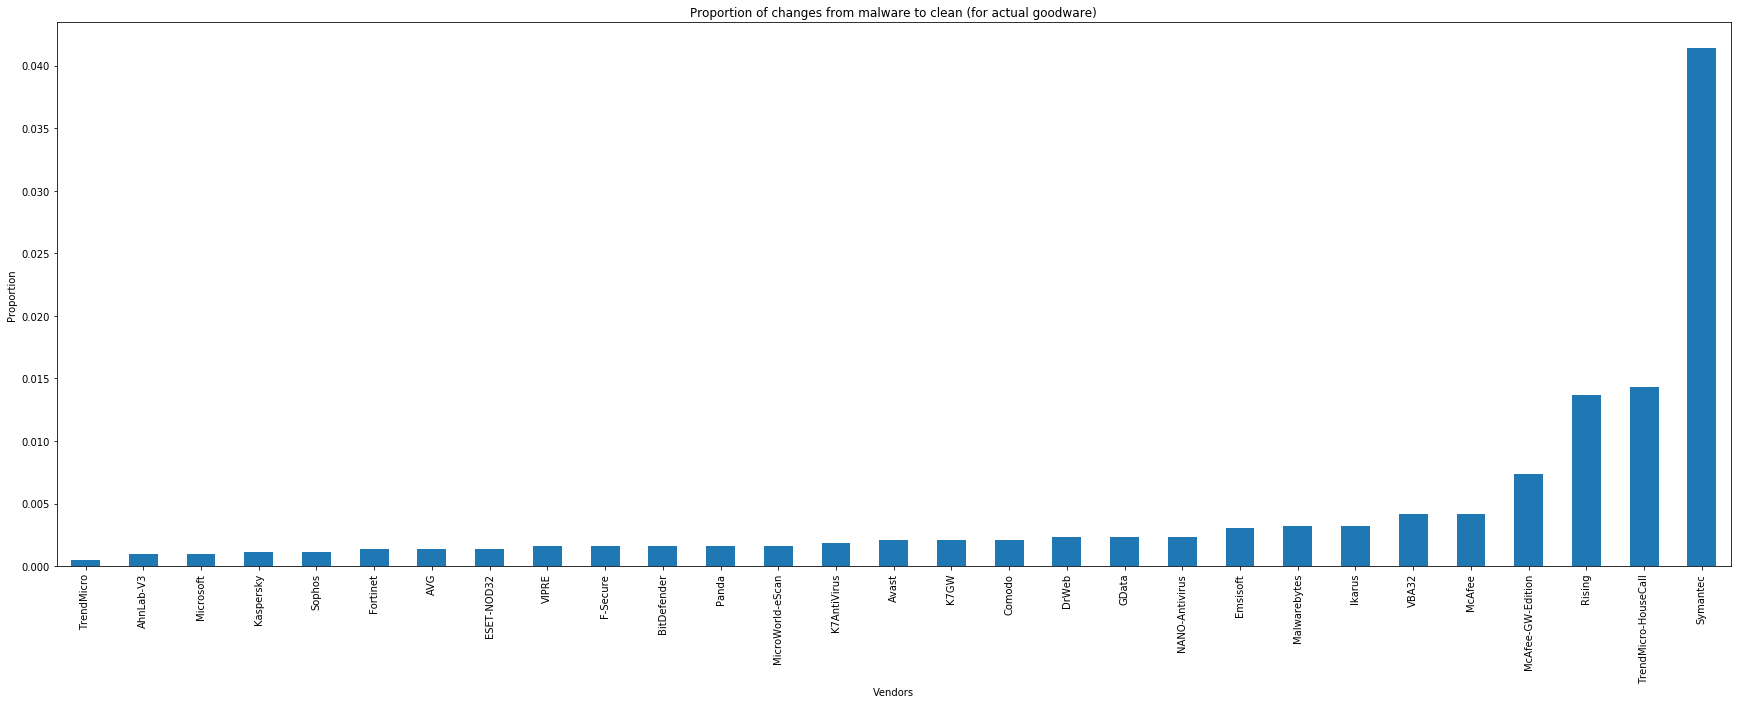

In [104]:
vendors_changes4 = dict()

for vendor in selected_vendors:
    first = clean_proportion[vendor].dropna().replace('Clean', np.nan)
    last = clean_proportion2[vendor].dropna().replace('Clean', np.nan)

    vendors_changes4[vendor] = (len(first[~first.isnull()]) - len(last[~last.isnull()])) / len(clean_last)

ax = pd.Series(vendors_changes4).sort_values().plot.bar(figsize=((30, 10)),
    title='Proportion of changes from malware to clean (for actual goodware)')
ax.set_xlabel('Vendors')
ax.set_ylabel('Proportion')
plt.show()